# System imbalance forecasting

Evaluate different forecasts. How accurate are they on different time horizons and how well does the accuracy translate into economic variables.  

This analysis also answers the research question **Which prediction methods obtain the most accurate result for 2h before delivery prediction of imbalance price?**

**Is the complexity of deep learning methods justified?**

**Used materials in analysis:**    
https://faculty.washington.edu/ezivot/econ584/notes/unitroot.pdf  
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3  
Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 10.04.2022  
https://www.statsmodels.org/stable/tsa.html  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math, copy, time
import seaborn

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
# from sklearn.metrics import mean_squared_error
# from statsmodels.tools.eval_measures import rmse, meanabs

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from  sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# pip install pmdarima
import pmdarima as pm

/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/da5id/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
2022-05-30 02:58:08.090443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-30 02:58:08.090466: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data preparation

Original data obtained from Baltic Transparency Dashboard, via API. Script, that puts together the dataset is in `data_miner.py`  

To deal with missing values, I use **cubic spline interpolation** imputing strategy

**2 different approaches**  
1) Take the hourly imbalance values and use hourly time step  
2) Take minute-based values and aggregate to arbitary time step

In [3]:
AGGREGATION_STEP = 60

In [4]:
def change_timeseries_aggregation_step(timeseries_df: pd.DataFrame, aggregation_step: int):
    '''
    Take univariate timeseries with 1min data and aggregate.
    :param timeseries:
    :param aggregation_step:
    :return:
    '''
    n_count = timeseries_df.shape[0]
    n_count_aggregated = round(n_count / aggregation_step)
    new_entries = {'from': [], 'aggregate': []}
    for i in range(0, n_count, aggregation_step):
        chunk = timeseries_df.iloc[i:(i + aggregation_step), :]
        aggregate = (chunk.iloc[:, 1].mean())

        new_entry_timestamp = str(chunk.index[0]).split('+')[0]
        new_entries['from'].append(new_entry_timestamp)
        new_entries['aggregate'].append(aggregate)
    aggregated_df = pd.DataFrame(data=new_entries)
    return aggregated_df

In [5]:
df_timeseries = pd.read_excel('../../data/imbalance_strategy/full_case_study/imbalance_volumes_2019_2022_2h_shift.xlsx', index_col=0, parse_dates=True)
df_timeseries.drop(['in_2h'], inplace=True, axis=1)

# df_timeseries

Select only training data!

In [6]:
df_timeseries = df_timeseries['2020']

In [7]:
df_timeseries[df_timeseries['Actual'].isna()]

,Actual
from,


In [8]:
df_timeseries['Actual'].interpolate(method='spline', order=3, inplace=True)

## Models

1) ARIMA timeseries models  
2) Exponential smoothing model  

---

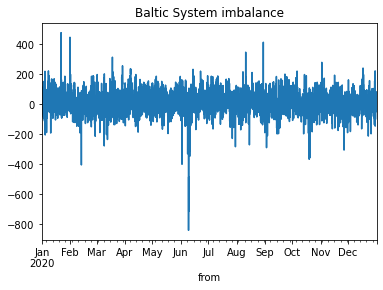

In [9]:
df_timeseries['Actual'].dropna().plot(title='Baltic System imbalance')
plt.show()

## 1. Statistical methods 

In this section, we look at the classical statistical methods for timeseries forecating. Specifically the Box-Jenkins method (ARIMA) and Exponential smoothing method.

## 1.1 ARIMA (Autoregressive Integrated Moving Average)

In order to find suitable model, I follow Box-Jenkins method. ARIMA model requires to define the AR, I and MA terms.  
**Steps:**  

0) Is the timeseries stationary? Stationarity guarantees, that the statistical characteristics will be similar in different times (strong - The random process PDF is the same at any $t$, weak - Random process characteristics (mean and variance are the same at any $t$.    

I use ADF Unit Root test, in order to objectively identify, whether the process has unit root ($|\phi| < 1$). The alternative test for  unit-root, is Phillips- Perron. The test statistic differs from the ADF, by ignoring all the serial correlation in test-regression (https://faculty.washington.edu/ezivot/econ584/notes/unitroot.pdf). This makes it prone to heteroscedacity.  

In addition, I use stationarity test KPSS (Kwiatkowski-Phillips-Schmidt-Shin), to see if ...

1) Determine the order of AR and MA terms first, by visually, looking at ACF and PACF plots - the ARIMA model should remove all autocorrelation structures from the timeseries, so the resulting model residuals do not have any autocorrelation structure (Box-Ljung Q-statistic test)   

2) Check the AIC criterions of models.  
3) 

Augmented Dickey-Fuller test statistic

$$y_t = \beta D_t + \phi y_{t-1} + \sum^{p}_{j=1}\psi_j\Delta y_{t-j} + \epsilon_t$$ 
where  
$D$ - Deterministic trend and constant  
$\beta$ - Regression model estimates (evaluated, using OLS)  


In [10]:
result_adf = adfuller(df_timeseries['Actual'])
critical_value = result_adf[4]['5%']
adf_stat = result_adf[0]

print(f"p-value: {result_adf[1]}")
print(f"Used lags: {result_adf[2]}")

if adf_stat < critical_value:
    print("H1: (the timeseries are difference stationary, the process has unit root)")
else:
    print("H0: The process is not stationary!")

p-value: 1.4669986159592121e-22
Used lags: 24
H1: (the timeseries are difference stationary, the process has unit root)


Test statistic for KPSS test: $$y_t = \beta D_t + \mu_t + u_t$$, where  
$D$ - Deterministic trend and constant  
$\beta$ - Regression model estimates (evaluated, using OLS)  
$$\mu_t = \mu_{t-1} + \epsilon_t, \epsilon_t \sim W N(0, \sigma^2_\epsilon)$$


In [11]:
result_kpss = kpss(df_timeseries['Actual'], nlags='auto')

critical_value = result_kpss[3]['5%']
kpss_stat = result_kpss[0]

print(f"p-value: {result_kpss[1]}")
print(f"Used lags: {result_kpss[2]}")
print(critical_value)
print(kpss_stat)

if kpss_stat > critical_value:
    print("H1: the timeseries are not trend stationary")
else:
    print("H0: the timeseries are trend stationary")

p-value: 0.015595100848878728
Used lags: 45
0.463
0.677453890662334
H1: the timeseries are not trend stationary


Look for autocorrelation visual patterns on ACF and PACF plots

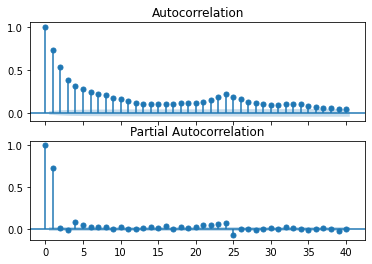

In [12]:
fig, axes = plt.subplots(2, 1, sharex=True)
plot_acf(df_timeseries['Actual'], ax=axes[0])
plot_pacf(df_timeseries['Actual'], ax=axes[1])
plt.show()

From the ACF&PACF plots, we can assume, that the process is probably AR(2), but to verify it, we calculate the AIC information criterion.  
$$\text{AIC} = -2 \log(L) + 2(p+q+k+1)$$

Test the following models:  
1) ARMA(1, 0)  
2) ARMA(2, 0)  
3) ARMA(3, 0)  
4) ARMA(2, 1)  
5) ARMA(2, 2)  
6) ARMA(3, 1)  
7) ARMA(3, 2)  

In [13]:
model = sm.tsa.arima.ARIMA(df_timeseries['Actual'], order=(1, 0, 0))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                 8784
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -46645.765
Date:                Mon, 30 May 2022   AIC                          93297.530
Time:                        02:58:15   BIC                          93318.772
Sample:                    01-01-2020   HQIC                         93304.767
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6221      1.937      6.516      0.000       8.826      16.419
ar.L1          0.7284      0.004    186.180      0.000       0.721       0.736
sigma2      2398.4423     17.555    136.626      0.000    2364.036    2432.849
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):             15710.65
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
model = sm.tsa.arima.ARIMA(df_timeseries['Actual'].dropna(), order=(2, 0, 0))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                 8784
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -46645.592
Date:                Mon, 30 May 2022   AIC                          93299.184
Time:                        02:58:16   BIC                          93327.507
Sample:                    01-01-2020   HQIC                         93308.834
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6221      1.955      6.457      0.000       8.791      16.454
ar.L1          0.7238      0.006    116.891      0.000       0.712       0.736
ar.L2          0.0063      0.007      0.857      0.391      -0.008       0.021
sigma2      2398.6099     17.662    135.806      0.000    2363.993    2433.227
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15653.42
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
model = sm.tsa.arima.ARIMA(df_timeseries['Actual'], order=(3, 0, 0))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                 8784
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -46644.244
Date:                Mon, 30 May 2022   AIC                          93298.488
Time:                        02:58:16   BIC                          93333.892
Sample:                    01-01-2020   HQIC                         93310.550
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6221      1.923      6.565      0.000       8.854      16.390
ar.L1          0.7239      0.006    116.531      0.000       0.712       0.736
ar.L2          0.0190      0.010      1.969      0.049    8.59e-05       0.038
ar.L3         -0.0175      0.008     -2.189      0.029      -0.033      -0.002
sigma2      2397.9017     17.732    135.228      0.000    2363.147    2432.656
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             15829.23
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model = sm.tsa.arima.ARIMA(df_timeseries['Actual'], order=(2, 0, 1))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                 8784
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -46620.677
Date:                Mon, 30 May 2022   AIC                          93251.355
Time:                        02:58:19   BIC                          93286.758
Sample:                    01-01-2020   HQIC                         93263.416
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5970      1.949      6.462      0.000       8.776      16.418
ar.L1         -0.2666      0.004    -65.218      0.000      -0.275      -0.259
ar.L2          0.7296      0.004    179.796      0.000       0.722       0.738
ma.L1          0.9929      0.002    440.154      0.000       0.988       0.997
sigma2      2384.7612     17.685    134.843      0.000    2350.098    2419.424
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             15506.10
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.19
Prob(H) (two-sided):                  0.03   Kurtosis:                         9.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
model = sm.tsa.arima.ARIMA(df_timeseries['Actual'], order=(2, 0, 2))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                 8784
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -46607.003
Date:                Mon, 30 May 2022   AIC                          93226.006
Time:                        02:58:24   BIC                          93268.490
Sample:                    01-01-2020   HQIC                         93240.479
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6081      3.421      3.686      0.000       5.903      19.313
ar.L1          1.6271      0.017     97.920      0.000       1.595       1.660
ar.L2         -0.6355      0.015    -42.652      0.000      -0.665      -0.606
ma.L1         -0.9143      0.019    -48.761      0.000      -0.951      -0.878
ma.L2         -0.0314      0.012     -2.627      0.009      -0.055      -0.008
sigma2      2377.5283     17.533    135.607      0.000    2343.165    2411.891
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             15667.82
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
model = sm.tsa.arima.ARIMA(df_timeseries['Actual'], order=(3, 0, 1))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                 8784
Model:                 ARIMA(3, 0, 1)   Log Likelihood              -46620.594
Date:                Mon, 30 May 2022   AIC                          93253.188
Time:                        02:58:30   BIC                          93295.672
Sample:                    01-01-2020   HQIC                         93267.662
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5786      1.946      6.465      0.000       8.765      16.392
ar.L1         -0.2635      0.007    -40.413      0.000      -0.276      -0.251
ar.L2          0.7283      0.005    152.710      0.000       0.719       0.738
ar.L3         -0.0044      0.008     -0.588      0.556      -0.019       0.010
ma.L1          0.9929      0.002    441.369      0.000       0.988       0.997
sigma2      2384.1348     17.725    134.508      0.000    2349.395    2418.875
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15538.39
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.19
Prob(H) (two-sided):                  0.03   Kurtosis:                         9.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model = sm.tsa.arima.ARIMA(df_timeseries['Actual'], order=(3, 0, 2))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                 8784
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -46585.584
Date:                Mon, 30 May 2022   AIC                          93185.167
Time:                        02:58:37   BIC                          93234.732
Sample:                    01-01-2020   HQIC                         93202.053
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6187      3.420      3.689      0.000       5.915      19.322
ar.L1          0.6577      0.012     55.792      0.000       0.635       0.681
ar.L2          0.9890      0.003    332.516      0.000       0.983       0.995
ar.L3         -0.6609      0.010    -66.654      0.000      -0.680      -0.641
ma.L1          0.0399      0.010      3.893      0.000       0.020       0.060
ma.L2         -0.9464      0.010    -95.025      0.000      -0.966      -0.927
sigma2      2361.6606     17.555    134.533      0.000    2327.254    2396.067
===================================================================================
Ljung-Box (L1) (Q):                   4.78   Jarque-Bera (JB):             15342.53
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.16
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From models with all statistically significant parameters, select the model with the **Lowest** AIC value

In [20]:
orders = [(1, 0, 0), (2, 0, 0), (3, 0, 0), (2, 0, 1), (2, 0, 2), (3, 0, 1), (3, 0, 2)]

In [21]:
aicc_values = []
for order in orders:
    model = sm.tsa.arima.ARIMA(df_timeseries['Actual'], order=order)
    fitted = model.fit()
    aic_value = fitted.aicc
    aicc_values.append(aic_value)


In [22]:
min_idx = np.argmin(aicc_values)
print(f"Best model: {orders[min_idx]}")

# Select the best
model = sm.tsa.arima.ARIMA(df_timeseries['Actual'], order=orders[min_idx])
fitted = model.fit()

Best model: (3, 0, 2)


See, if the residuals are white noise (no autocorrelation)

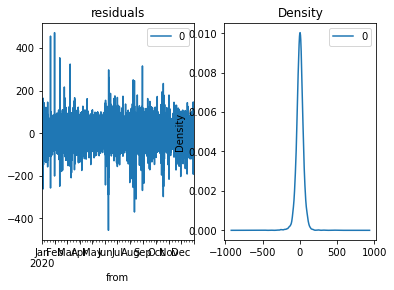

In [23]:
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title='residuals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

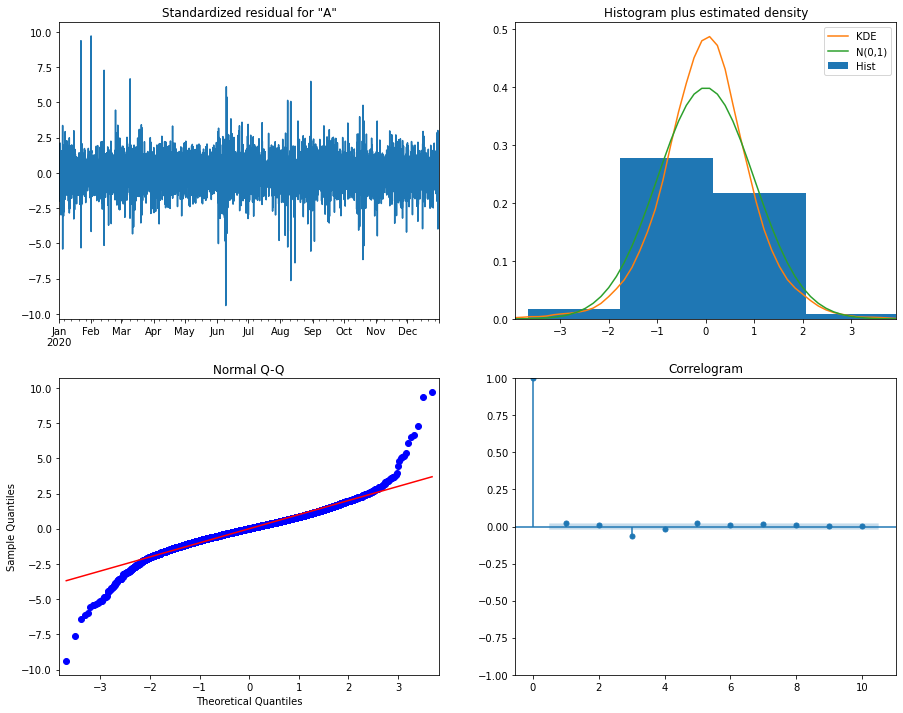

In [24]:
fitted.plot_diagnostics(figsize=(15, 12))
plt.show()

* The tails of the KDE are relatively not-heavy, which is suprising, considering, that most of the real processes have heavy tails  
* The correlogram shows, that the autocorrelation structure is removed and residuals are mostly white noise (MA(0) process) 

## Validation 

Validate the model, and analyze the results of different forecast horizons. Use cross-validation as a validation method and RMSE and MAPE as metrics.  

Since the results of tests described above gave results, that timeseries are stationary, we can take use parts of the original series as training-test data, as the probability distribution must be the same. 

The **error** is different from residuals, in a way that residuals are for training errors, but error considers test data. 
$$e_{T+h} = y_{T+h} - \hat{y}_{T+h|T}$$

where $T$ is the size of training data

Time series data is harder to cross-validate, because of the sequential nature

In [25]:
def train_test_split(data, train_size):
    x_len = data.shape[0]
    train_size = int(x_len * train_size)

    train = data.iloc[:train_size, data.columns.get_loc('Actual')]
    test = data.iloc[train_size:, data.columns.get_loc('Actual')]
    return train, test

<AxesSubplot:xlabel='from'>

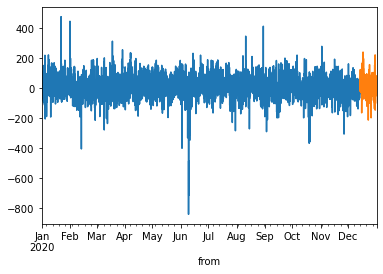

In [26]:
train, test = train_test_split(df_timeseries, 0.95)
model = sm.tsa.arima.ARIMA(train, order=(3, 0, 2))
fitted = model.fit()
train.plot()
test.plot()

In [27]:
from sklearn.model_selection import TimeSeriesSplit

# Returns 10 folds of [training], test 
tscv = TimeSeriesSplit(n_splits=10)
for train_idx, test_idx in tscv.split(train):
    X_train, X_test = df_timeseries.iloc[train_idx], df_timeseries.iloc[test_idx]
#     y_train, y_test = df_timeseries[train_idx], df_timeseries[test_idx]

    print("TRAIN:", X_train)
    print()
    print("TEST:", X_test)

    model = sm.tsa.arima.ARIMA(X_train['Actual'], order=(3, 0, 1))
    fitted = model.fit()
    
    fitted.get_prediction(start=X_test.index[0], end=X_test.index[-1], dynamic=False)
    


TRAIN:                      Actual
from                       
2020-01-01 00:00:00 -81.387
2020-01-01 01:00:00 -64.872
2020-01-01 02:00:00   2.369
2020-01-01 03:00:00  15.039
2020-01-01 04:00:00  21.496
...                     ...
2020-02-01 15:00:00   2.472
2020-02-01 16:00:00  24.262
2020-02-01 17:00:00 -62.587
2020-02-01 18:00:00 -42.319
2020-02-01 19:00:00  -6.449

[764 rows x 1 columns]

TEST:                      Actual
from                       
2020-02-01 20:00:00  51.992
2020-02-01 21:00:00  56.247
2020-02-01 22:00:00  49.337
2020-02-01 23:00:00  84.046
2020-02-02 00:00:00  71.574
...                     ...
2020-03-04 05:00:00  -1.718
2020-03-04 06:00:00  21.711
2020-03-04 07:00:00  35.013
2020-03-04 08:00:00 -10.955
2020-03-04 09:00:00 -24.037

[758 rows x 1 columns]
TRAIN:                      Actual
from                       
2020-01-01 00:00:00 -81.387
2020-01-01 01:00:00 -64.872
2020-01-01 02:00:00   2.369
2020-01-01 03:00:00  15.039
2020-01-01 04:00:00  21.496
...    

### Naive baseline model

The more complicated models must perform better than the naive baseline. Naive baseline forecast just last seen value.

In [28]:
from sklearn.metrics import mean_squared_error


def validate_naive_forecast(train, test, steps=1):
    history = [x for x in train]
    predictions = []
    predicted_observations=[]
    reduced_test_size = steps -1

    for i in range(len(test) - reduced_test_size):
        yhat = history[-1]
        predictions.append(yhat)
        current_observation = test[i]
        predicted_observation = test[i+steps-1]
        
        predicted_observations.append(predicted_observation)
        history.append(current_observation)
        # print(f'Forecast {yhat}, Actual {predicted_observation}')

    predicted_observations = np.array(predicted_observations)
    rmse = round(np.sqrt(mean_squared_error(predicted_observations, predictions)), 2)
    mape = round(np.mean(np.abs(predictions - predicted_observations)/np.abs(predicted_observations)), 2)
    mae = round(np.mean(np.abs(predictions - predicted_observations)), 2)
    
    error_metrics = {'rmse': rmse, 'mape': mape, 'mae': mae}
    return error_metrics, predictions


In [29]:
error_metrics, predictions = validate_naive_forecast(train, test, steps=2)
print("Naive forecast metrics")
print(f"RMSE: {error_metrics['rmse']}")
print(f"MAPE: {error_metrics['mape']}")
print(f"MAE: {error_metrics['mae']}")

Naive forecast metrics
RMSE: 62.22
MAPE: 9.88
MAE: 46.65


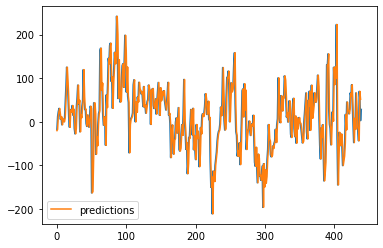

In [30]:
plt.plot(test.values)
plt.plot(predictions, label='predictions')
plt.legend()

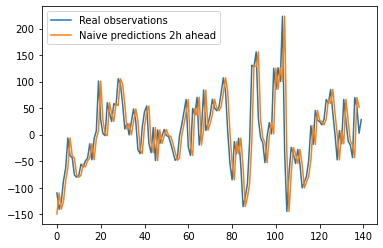

In [31]:
plt.plot(test.values[300:], label='Real observations')
plt.plot(predictions[300:], label='Naive predictions 2h ahead')
plt.legend()
plt.show()

In [32]:
error_metrics, predictions = validate_naive_forecast(train, test, steps=3)
print("Naive forecast metrics")
print(f"RMSE: {error_metrics['rmse']}")
print(f"MAPE: {error_metrics['mape']}")
print(f"MAE: {error_metrics['mae']}")

Naive forecast metrics
RMSE: 71.86
MAPE: 9.41
MAE: 54.61


In [33]:
error_metrics, predictions = validate_naive_forecast(train, test, steps=4)
print("Naive forecast metrics")
print(f"RMSE: {error_metrics['rmse']}")
print(f"MAPE: {error_metrics['mape']}")
print(f"MAE: {error_metrics['mae']}")

Naive forecast metrics
RMSE: 77.08
MAPE: 7.44
MAE: 58.66


### In-sample Naive error metrics

Real case study results will be provided as a separate notebook  
**2h ahead**:

RMSE: 62.22   
MAE: 46.65  

**3h ahead**: 

RMSE: 71.86  
MAE: 54.61  

**4h ahead**:  

RMSE: 77.08  
MAE: 58.66  

## Get ARIMA error metrics

To reduce time, don't refit the model in every step as this would be unnecessary

In [34]:
def validate_arima_forecast(fitted, train, test, steps=1) -> dict():
    """
    For each step predict the "steps" new observations. Add up the prediction errors.
    Error is for the whole length of the test data (same length in every validation, to compare metrics)
    
    :param fitted: ARIMAResults fitted model.
    """
    RE_FIT_ARIMA_ITERATIONS=20
    predictions = []
    test = test.values
    reduced_test_size = steps - 2
    predicted_observations=[]
    for i in range(len(test) - reduced_test_size):
        
        yhat = fitted.forecast(steps)[-1]
        predictions.append(yhat)  # Take the value corresponding to forecast horizon.
        
        refit=False
        
        # It is not necessary, to refit every time, but every 20 times will be optimal.
#         if i % RE_FIT_ARIMA_ITERATIONS == 0:
#             refit=True
        
        # We add 1 observation value at every step, not depending on forecast horizon!
        observation = df_timeseries[len(fitted.fittedvalues):len(fitted.fittedvalues)+steps]
    
        fitted = fitted.append(observation.iloc[[0]], refit=refit)  # ARIMAResults object append. D
        predicted_observations.append(observation.iloc[-1, 0])  
        
        # print(f'Forecast {yhat}, Actual {observation.iloc[-1, 0]}')

    predicted_observations = np.array(predicted_observations)
    rmse = round(np.sqrt(mean_squared_error(predicted_observations, predictions)), 2)
    mape = round(np.mean(np.abs(predictions - predicted_observations)/np.abs(predicted_observations)), 2)
    mae = round(np.mean(np.abs(predictions - predicted_observations)), 2)
    
    error_metrics = {'rmse': rmse, 'mape': mape, 'mae': mae}

    return error_metrics, predictions
    

In [35]:
model = sm.tsa.arima.ARIMA(train, order=(3, 0, 2))
fitted = model.fit()

In [36]:
test

from
2020-12-13 16:00:00   -17.273
2020-12-13 17:00:00    12.599
2020-12-13 18:00:00    23.657
2020-12-13 19:00:00    30.783
2020-12-13 20:00:00    18.723
                        ...  
2020-12-31 19:00:00   -43.471
2020-12-31 20:00:00    69.884
2020-12-31 21:00:00    51.770
2020-12-31 22:00:00     2.744
2020-12-31 23:00:00    28.456
Name: Actual, Length: 440, dtype: float64

In [37]:
error_metrics, predictions = validate_arima_forecast(fitted, train, test, steps=2)
print("ARIMA  forecast metrics")
print(f"RMSE: {error_metrics['rmse']}")
print(f"MAPE: {error_metrics['mape']}")
print(f"MAE: {error_metrics['mae']}")

ARIMA  forecast metrics
RMSE: 55.33
MAPE: 6.0
MAE: 41.54


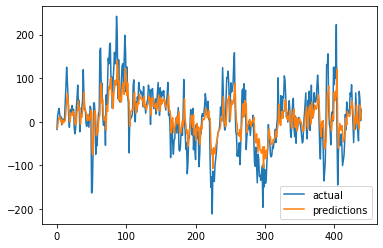

In [38]:
plt.plot(test.values, label='actual')
plt.plot(predictions, label='predictions')
plt.legend()

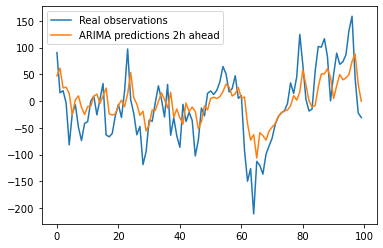

In [39]:
plt.plot(test.values[160:260], label='Real observations')
plt.plot(predictions[160:260], label='ARIMA predictions 2h ahead')
plt.legend()
plt.show()

In [40]:
error_metrics, predictions = validate_arima_forecast(fitted, train, test, steps=3)
print("ARIMA  forecast metrics")
print(f"RMSE: {error_metrics['rmse']}")
print(f"MAPE: {error_metrics['mape']}")
print(f"MAE: {error_metrics['mae']}")

ARIMA  forecast metrics
RMSE: 60.95
MAPE: 4.77
MAE: 46.36


In [41]:
error_metrics, predictions = validate_arima_forecast(fitted, train, test, steps=4)
print("ARIMA  forecast metrics")
print(f"RMSE: {error_metrics['rmse']}")
print(f"MAPE: {error_metrics['mape']}")
print(f"MAE: {error_metrics['mae']}")

ARIMA  forecast metrics
RMSE: 63.5
MAPE: 3.75
MAE: 48.66


## ARIMA results 

The 2021 data is left for backtesting, and this is the validation on test data in 2020.  
The backtesting results are brought out in separate file. Current analysis serves purpose of analyzing the forecast horizon effects on different models  

**2h ahead:**  
RMSE: 55.33  
MAE: 41.54  

**3h ahead:**  
RMSE: 60.95  
MAE: 46.36

**4h ahead:**  
RMSE: 63.5  
MAE: 48.66

Experiment translating the regression problem to a classification one

In [42]:
right_side = 0
total = 0
for i in range(len(predictions)):
    if test[i] > 10:
        if predictions[i] > 0:
            right_side+=1
        total+=1
    elif test[i] < -10:
        if predictions[i] < 0:
            right_side +=1
        total+=1
print(f'Directional accuracy: {right_side/total}')

Directional accuracy: 0.8


## Exponential Smoothing

In [43]:
model = sm.tsa.arima.ARIMA(train, order=(0, 1, 1))
fitted = model.fit()

In [44]:
error_metrics, predictions = validate_arima_forecast(fitted, train, test, steps=2)
print("ARIMA  forecast metrics")
print(f"RMSE: {error_metrics['rmse']}")
print(f"MAPE: {error_metrics['mape']}")
print(f"MAE: {error_metrics['mae']}")

ARIMA  forecast metrics
RMSE: 60.96
MAPE: 9.39
MAE: 45.89


In [45]:
error_metrics, predictions = validate_arima_forecast(fitted, train, test, steps=3)
print("ARIMA  forecast metrics")
print(f"RMSE: {error_metrics['rmse']}")
print(f"MAPE: {error_metrics['mape']}")
print(f"MAE: {error_metrics['mae']}")

ARIMA  forecast metrics
RMSE: 69.93
MAPE: 8.53
MAE: 53.24


In [46]:
error_metrics, predictions = validate_arima_forecast(fitted, train, test, steps=4)
print("ARIMA  forecast metrics")
print(f"RMSE: {error_metrics['rmse']}")
print(f"MAPE: {error_metrics['mape']}")
print(f"MAE: {error_metrics['mae']}")

ARIMA  forecast metrics
RMSE: 74.83
MAPE: 6.88
MAE: 56.81


## Exponential smoothing results

**2h ahead:**  
RMSE: 60.96  
MAE: 45.89   

**3h ahead:**   
RMSE: 69.93  
MAE: 53.24  

**4h ahead:**  
RMSE: 74.83  
MAE: 56.81  

## Interpretation and model selection


Look at RMSE only  

|  df| Naive  | Arima   | Exponential Smoothing  |   |
|----------|---|---|---|---|
| 2h ahead  | 62.22 |55.33 | 60.96  |   |
| 3h ahead  | 71.86  | 60.95  | 69.93  |   |
| 4h ahead  | 77.08  | 63.5  | 74.83  |   |

It can be interpreted, that ARIMA performs the best and more importantly, the results get worse by increasing the forecast horizon. However, ARIMA "decays" more slowly than Naive and Exponential Smoothing model

This is for manually checking the logic of validation steps. To make sure, that no infomation leaks to validation (non-antipacivity)

---

In [47]:
train

from
2020-01-01 00:00:00   -81.387
2020-01-01 01:00:00   -64.872
2020-01-01 02:00:00     2.369
2020-01-01 03:00:00    15.039
2020-01-01 04:00:00    21.496
                        ...  
2020-12-13 11:00:00   -65.669
2020-12-13 12:00:00   -36.279
2020-12-13 13:00:00   -24.558
2020-12-13 14:00:00   -30.501
2020-12-13 15:00:00   -20.155
Name: Actual, Length: 8344, dtype: float64

In [48]:
model = sm.tsa.arima.ARIMA(train, order=(3, 0, 2))
fitted=model.fit()
prediction = fitted.forecast(2)
prediction

2020-12-13 16:00:00   -13.586719
2020-12-13 17:00:00   -14.781286
Freq: H, Name: predicted_mean, dtype: float64

In [49]:

prediction_2step=prediction[1]
prediction_2step

-14.781286496907558

In [50]:
observation=df_timeseries[len(fitted.fittedvalues):len(fitted.fittedvalues)+2]
observation.iloc[:-1]

,Actual
from,
2020-12-13 16:00:00,-17.273


In [51]:
forecast= fitted.get_forecast(len(test), alpha=0.05)

In [52]:
conf_int = forecast.conf_int()

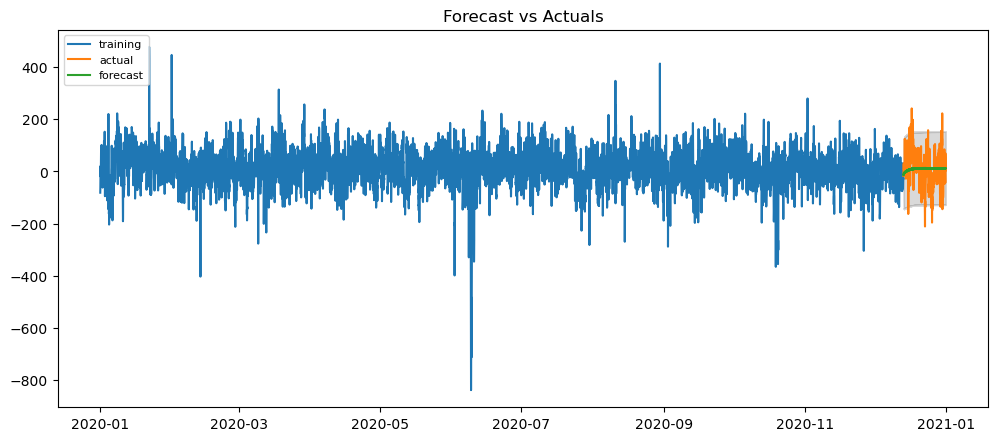

In [53]:
# Make as pandas series
forecast_series = pd.Series(forecast.predicted_mean, index=test.index)
lower_series = pd.Series(conf_int.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(forecast_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

A very illustrative plot, that shows, why short term makes a lot more sense in this problem than long-term forecast horizon

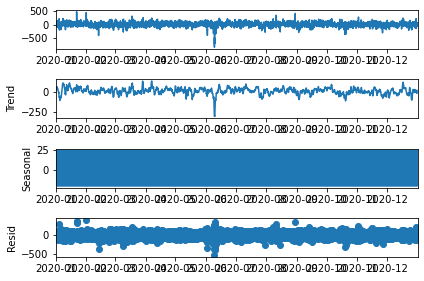

In [54]:
result = seasonal_decompose(df_timeseries.dropna(), model='additive')
result.plot()
plt.show()